<h1>Honorifics Data Analysis</h1>

In [1]:
# import needed packages
from functions import *

# read in data
data = pd.read_csv("data_honorifics.csv")

# random seed for clustering
randomSeed = 5

<h2>Part One: Clustering Based on Mapped Values</h2>
For the first try at clustering the honorifics data, I created a vocab list and mapped each answer to a number. Then clustered the dataset from there. The benefits of this approach are that it's easy to implement and easy to use for clustering. The drawbacks are that using Kmeans to cluster will probably result in slightly skewed clustering since numbers that are closer to each other will be treated as more similar (which is not necessarily true since the numbers have very little meaning in this context). This issue will be addressed in the second section.

In [2]:
# isolate the question portion of the dataset
questions = data.iloc[:,7:24]
questions = questions.fillna("I don't know")

vocab = []
qcols = []
# get questions column names
for question in range(1,18):
    qcols.append("Q"+str(question))

# get total unique responses in survey
stackedDf = questions.stack()
vocab = stackedDf.unique()

Below is the dictionary created to map string values to numbers. A sample is printed out.

In [3]:
# make a dict to map words to numbers
dict = {}
for val in range(len(vocab)):
    dict[vocab[val]]=val
for i,key in enumerate(dict.keys()):
    print(key+":"+str(dict[key]))
    if i==5:
        break

Grandma:0
stone:1
Teacher:2
Teacup:3
Thought:4
Cat:5


Next we take the dictionary and use it to create a dataframe where the string values are mapped to numbers. This dataframe is what we will use to create clusters.

In [4]:
# map the dataframe vals to nums
df = pd.DataFrame()
for q in qcols:
    df[q] = questions[q].map(dict)
# fill nas with idks
df = df.fillna(dict["I don\'t know"])
df

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  Q11  Q12  Q13  Q14  Q15  Q16  Q17
0    0   1   2   3   1   2   4   3   5    5    6    7    8    9   10   11   12
1    4   1   2   3   1   2   4   3   5    5   13   14    8    9   15   11   12
2    0  13   2  13  16   2  13  17   9   13    8   13    8    9   13   18   13
3    0   1   2   3   1   2  15   3   5   15    8   19    8   20   15   18    9
4    0   1   2   3   1   2   4   3   5    5    6    7    8    9   21   11   12
..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...
62   0  13   2  13  13   2  32  13  13   13   13   13    8    9   15   11   13
63   0   1   2   3   1   2  32   3   5    5    8   19    8   15   15   15   15
64   0   1   2   3   1   2   4   3   5    5    6    7    8   22   10   15   12
65   0   1   2   3   1   2  32   3   9    5    8   19    8   20   15   15   15
66   4   1   2   3   1   2   4   3   5    5    8    7    8   22   10   11   12

[67 rows x 17 columns]

Now that we have our new dataframe, we can perform clustering (using Kmeans). We begin by looking at the inertias of different kmeans cluster numbers to determine an appropriate number of clusters for our data. As you can see from the below graph, there is no clear elbow. Further analysis will all be performed on sets of 6 clusters.

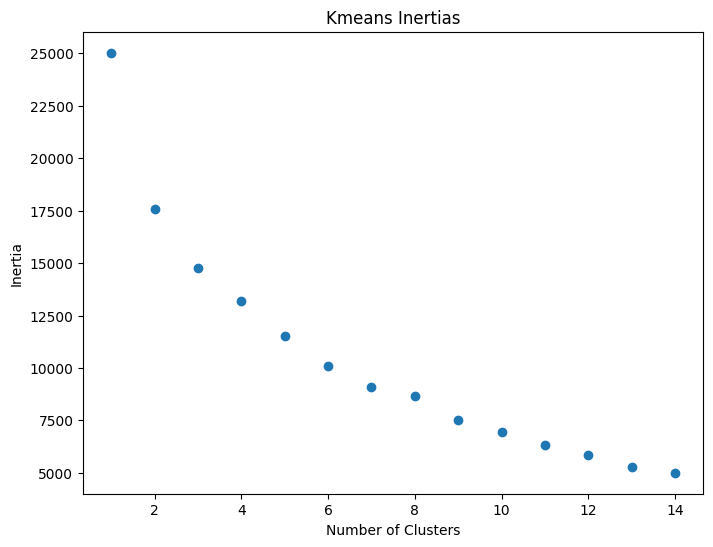

In [5]:
# graph cluster inertias for 1-15 clusters
clusterDf = doKmeans(df,range(1,15),randomSeed=randomSeed)

<h3>Age Across Clusters</h3>
Now that we have clusters to work with, we can see if there are any age differences between clusters of responses. As you can tell, there are some age differences between clusters, but when we run statistical analyses the age differences are shown to not be significant.

In [6]:
# add age to the cluster df
clusterDf["Age"]=data["Age"]
# print the cluster sets for 6 clusters
rows6 = printClusterSetAge(clusterDf,6)
print(f_oneway(*rows6,nan_policy="omit"))

Cluster 0
mean: 28.0

Cluster 1
mean: 34.5

Cluster 2
mean: 24.263157894736842

Cluster 3
mean: 25.75

Cluster 4
mean: 30.166666666666668

Cluster 5
mean: 19.666666666666668

F_onewayResult(statistic=1.2274814354764665, pvalue=0.30991000999963997)


To further confirm these results, we do the same analysis on 2, 4, and 8 clusters of the data.

In [7]:
print("Two Clusters: ")
rows2 = printClusterSetAge(clusterDf,2)
print("--------------------------------\nFour Clusters: ")
rows4 = printClusterSetAge(clusterDf,4)
print("--------------------------------\nEight Clusters: ")
rows8 = printClusterSetAge(clusterDf,8)

Two Clusters: 
Cluster 0
mean: 26.372093023255815

Cluster 1
mean: 29.5

--------------------------------
Four Clusters: 
Cluster 0
mean: 26.5625

Cluster 1
mean: 34.5

Cluster 2
mean: 26.25925925925926

Cluster 3
mean: 25.75

--------------------------------
Eight Clusters: 
Cluster 0
mean: 28.875

Cluster 1
mean: 36.57142857142857

Cluster 2
mean: 25.782608695652176

Cluster 3
mean: 23.0

Cluster 4
mean: 29.714285714285715

Cluster 5
mean: 21.5

Cluster 6
mean: 22.333333333333332

Cluster 7
mean: 19.666666666666668



Below is the statistical analyses of the age for 2, 4, and 8 clusters. None of them are statistically significant.

In [8]:
# ttest on clusters ages
# no significant
print(ttest_ind(list(rows2[0]),list(rows2[1]),nan_policy="omit"))
print(f_oneway(*rows4,nan_policy="omit"))
print(f_oneway(*rows8,nan_policy="omit"))

TtestResult(statistic=-0.8899559262088101, pvalue=0.3773658821898026, df=55.0)
F_onewayResult(statistic=0.937386376494588, pvalue=0.42918935134444425)
F_onewayResult(statistic=1.2762466067371379, pvalue=0.28162824838667305)


<h2>Part Two: Clustering Based on One Hot Encoding</h2>
In order to address the concerns from the mapping (where numbers that are close by will be clustered closer), we will then map the data using one-hot-encoding principals. Each question will be split into several columns with a column for each possible response, and the columns will simply contain binary data. The idea is that since the questions are now represented with binary data, all the numbers are equally distant from one another. We will repeat the same clustering process with the one-hot-encoded data.

In [9]:
encoded = pd.DataFrame()
for col in questions.columns:
    for val in questions[col].unique():
        encoded[col+"-"+val]=(questions[col]==val).map({True: 1, False: 0})
encoded

Q1-Grandma  Q1-Thought  Q1-I don't know  Q2-stone  Q2-I don't know  \
0            1           0                0         1                0   
1            0           1                0         1                0   
2            1           0                0         0                1   
3            1           0                0         1                0   
4            1           0                0         1                0   
..         ...         ...              ...       ...              ...   
62           1           0                0         0                1   
63           1           0                0         1                0   
64           1           0                0         1                0   
65           1           0                0         1                0   
66           0           1                0         1                0   

    Q2-Listener  Q3-Teacher  Q3-I don't know  Q4-Teacup  Q4-I don't know  ...  \
0             0           1                0          1                0  ...   
1             0           1                0          1                0  ...   
2             0           1                0          0                1  ...   
3             0           1                0          1                0  ...   
4             0           1                0          1                0  ...   
..          ...         ...              ...        ...              ...  ...   
62            0           1                0          0                1  ...   
63            0           1                0          1                0  ...   
64            0           1                0          1                0  ...   
65            0           1                0          1                0  ...   
66            0           1                0          1                0  ...   

    Q16-Murderer  Q16-Mother  Q16-Other  Q16-Listener  Q16-I don't know  \
0              1           0          0             0                 0   
1              1           0          0             0                 0   
2              0           1          0             0                 0   
3              0           1          0             0                 0   
4              1           0          0             0                 0   
..           ...         ...        ...           ...               ...   
62             1           0          0             0                 0   
63             0           0          0             1                 0   
64             0           0          0             1                 0   
65             0           0          0             1                 0   
66             1           0          0             0                 0   

    Q17-Car  Q17-I don't know  Q17-Father  Q17-Listener  Q17-B  
0         1                 0           0             0      0  
1         1                 0           0             0      0  
2         0                 1           0             0      0  
3         0                 0           1             0      0  
4         1                 0           0             0      0  
..      ...               ...         ...           ...    ...  
62        0                 1           0             0      0  
63        0                 0           0             1      0  
64        1                 0           0             0      0  
65        0                 0           0             1      0  
66        1                 0           0             0      0  

[67 rows x 68 columns]

Once again we then perform Kmeans for a number of cluster values, and graph the inertias.

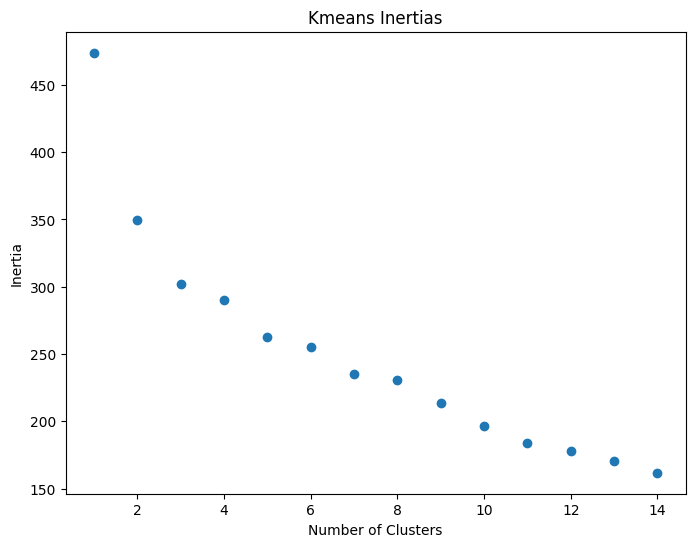

In [10]:
# graph cluster inertias for 1-15 clusters
encodedClusters = doKmeans(encoded,range(1,15),randomSeed=randomSeed)

Now we can once again look at some of the cluster sets and see if there are any significant age differences. Below we look at 3, 5, and 9 clusters, and none of the age differences are significant.

In [11]:
# add age to the cluster df
encodedClusters["Age"]=data["Age"]
# print the cluster sets for 6 clusters
print("Three Clusters: ")
rows3 = printClusterSetAge(encodedClusters,3)
print("--------------------------------\nFive Clusters: ")
rows5 = printClusterSetAge(encodedClusters,5)
print("--------------------------------\nNine Clusters: ")
rows9 = printClusterSetAge(encodedClusters,9)

# test significance of age diffs
print(f_oneway(*rows3,nan_policy="omit"))
print(f_oneway(*rows5,nan_policy="omit"))
print(f_oneway(*rows9,nan_policy="omit"))

Three Clusters: 
Cluster 0
mean: 27.866666666666667

Cluster 1
mean: 26.37142857142857

Cluster 2
mean: 29.428571428571427

--------------------------------
Five Clusters: 
Cluster 0
mean: 30.666666666666668

Cluster 1
mean: 26.529411764705884

Cluster 2
mean: 30.333333333333332

Cluster 3
mean: 25.5

Cluster 4
mean: 24.0

--------------------------------
Nine Clusters: 
Cluster 0
mean: 19.0

Cluster 1
mean: 24.476190476190474

Cluster 2
mean: 37.0

Cluster 3
mean: 27.714285714285715

Cluster 4
mean: 29.846153846153847

Cluster 5
mean: 22.0

Cluster 6
mean: 25.0

Cluster 7
mean: 31.166666666666668

Cluster 8
mean: 24.0

F_onewayResult(statistic=0.24425602643843397, pvalue=0.7841477565782357)
F_onewayResult(statistic=0.33947594280809074, pvalue=0.8500898271491188)
F_onewayResult(statistic=0.805665322752361, pvalue=0.6007790909458117)


<h3>Importance of each Question in Explaining Variance</h3>
In an effort to find out which questions were most used in clustering responses, we performed PCA on the data and looked at the explained_variance_ratio

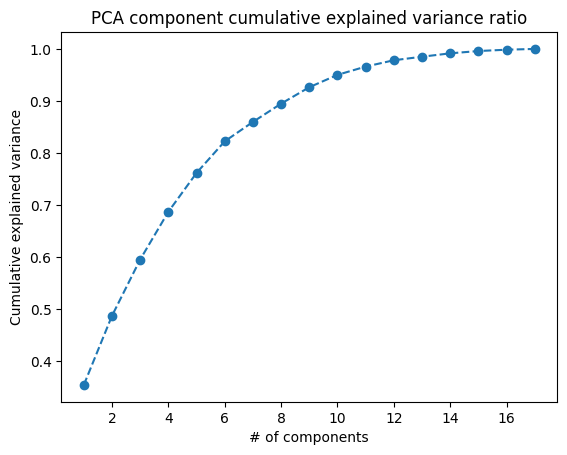

In [40]:
df2 = df.drop('Age',axis=1)

pca = PCA()
pca.fit(df2)
x = pca.explained_variance_ratio_

# plotting the explained variance of each number of components
# saves the plot to html_files
plt.plot(range(1,18),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.title("PCA component cumulative explained variance ratio")
plt.xlabel("# of components")
plt.ylabel("Cumulative explained variance")
plt.savefig("../html_files/explainedVariance.png")
plt.show()

To determine which questions are most impactful, we can look at the components of the pca test. The below dataframe contains the information. The columns are the questions and each row represents a division of the participant responses into that many parts (row one keeps the data whole, row 2 divides the data into 2 parts, and so on). Higher numbers mean more impact on the division.

In [38]:
componentImportance = pd.DataFrame(pca.components_,columns=questions.drop('Age',axis=1).columns).abs()
componentImportance.index += 1
componentImportance

Q1        Q2        Q3        Q4        Q5        Q6        Q7  \
1   0.065261  0.251104  0.023802  0.235609  0.501119  0.089672  0.381117   
2   0.034498  0.034282  0.008624  0.027916  0.376160  0.065253  0.672585   
3   0.017298  0.162432  0.013355  0.176231  0.083258  0.043949  0.212373   
4   0.107294  0.177194  0.053273  0.131784  0.114861  0.046062  0.369638   
5   0.151197  0.154113  0.075536  0.159133  0.030143  0.066753  0.385226   
6   0.071561  0.243183  0.044679  0.200587  0.016023  0.113983  0.098938   
7   0.132750  0.073289  0.062504  0.018598  0.158359  0.198153  0.052940   
8   0.065623  0.535107  0.033691  0.392041  0.131747  0.418975  0.156695   
9   0.167556  0.153362  0.106363  0.119538  0.278873  0.418319  0.121631   
10  0.397828  0.074563  0.220901  0.008614  0.187006  0.271550  0.119426   
11  0.091008  0.120108  0.086236  0.148443  0.022125  0.044426  0.042613   
12  0.236501  0.083503  0.175955  0.065746  0.108361  0.466332  0.047012   
13  0.065969  0.079904  0.050287  0.015687  0.580763  0.120766  0.000153   
14  0.735312  0.327546  0.168556  0.003407  0.061300  0.468468  0.028652   
15  0.108782  0.045630  0.057336  0.242140  0.274132  0.103231  0.028039   
16  0.178783  0.578241  0.153999  0.742795  0.021003  0.122289  0.014037   
17  0.305679  0.052882  0.909477  0.155977  0.045307  0.153519  0.014628   

          Q8        Q9       Q10       Q11       Q12       Q13       Q14  \
1   0.439146  0.152758  0.234916  0.107855  0.286691  0.049657  0.223147   
2   0.336405  0.022740  0.002778  0.010007  0.341557  0.024030  0.241424   
3   0.100657  0.050326  0.118706  0.497335  0.102624  0.190375  0.540256   
4   0.016921  0.022529  0.063464  0.465577  0.739914  0.059523  0.041608   
5   0.053496  0.078174  0.115552  0.446973  0.164288  0.163233  0.617430   
6   0.093568  0.015567  0.097087  0.482601  0.346636  0.201084  0.103533   
7   0.101245  0.019877  0.122275  0.227548  0.026759  0.779822  0.335693   
8   0.212725  0.063015  0.238469  0.064382  0.199240  0.030775  0.227396   
9   0.177975  0.125248  0.636194  0.117082  0.001891  0.383401  0.111336   
10  0.053219  0.022225  0.232402  0.007513  0.041512  0.191130  0.102171   
11  0.237062  0.156759  0.128066  0.031041  0.174227  0.003407  0.099919   
12  0.103983  0.119214  0.562783  0.075347  0.032176  0.276599  0.007225   
13  0.615809  0.449237  0.035272  0.012067  0.075993  0.071665  0.047784   
14  0.077646  0.019193  0.152560  0.113667  0.014410  0.123126  0.062373   
15  0.340884  0.824847  0.003779  0.028799  0.120467  0.014297  0.050371   
16  0.092699  0.100559  0.104948  0.010608  0.044324  0.021800  0.016238   
17  0.069872  0.121472  0.068292  0.033739  0.002613  0.001068  0.011369   

         Q15       Q16       Q17  
1   0.184399  0.142972  0.017312  
2   0.300875  0.008091  0.136923  
3   0.493382  0.176271  0.029491  
4   0.051508  0.045428  0.076758  
5   0.293056  0.156540  0.035276  
6   0.643739  0.176187  0.048914  
7   0.222684  0.227808  0.072261  
8   0.217592  0.010154  0.295018  
9   0.104572  0.099849  0.095570  
10  0.054958  0.731053  0.144166  
11  0.038021  0.046854  0.895217  
12  0.000996  0.481516  0.116251  
13  0.067974  0.173856  0.064448  
14  0.091162  0.170951  0.013459  
15  0.061665  0.008789  0.137921  
16  0.006439  0.019416  0.098324  
17  0.000234  0.021136  0.020673

To make sense of the above data, we look at the sum and mean for each column. We then compare each column to each other to see if any column overall has a greater impact on the data. The anova test reveals no significant differences between columns in overall divisions, but did reveal a significant difference when only looking at the most valid division numbers (2-6). A tukey test output reveals that Question 11 was only significantly different mean. <b>Question 11 had a larger impact on the component analysis than any of the other questions.</b>

In [54]:
totalImportance = pd.DataFrame()
totalImportance['Sum']=componentImportance.sum()
totalImportance['Mean']=componentImportance.mean()
'''for col in totalImportance.columns:
    info = [componentImportance.sum().iloc[0],componentImportance.mean().iloc[0]]
    totalImportance[col]=info'''
totalImportance

Sum      Mean
Q1   2.932899  0.172523
Q2   3.146443  0.185085
Q3   2.244574  0.132034
Q4   2.844246  0.167309
Q5   2.990540  0.175914
Q6   3.211700  0.188924
Q7   2.745703  0.161512
Q8   3.123313  0.183724
Q9   2.363739  0.139043
Q10  2.917543  0.171620
Q11  2.732142  0.160714
Q12  2.715321  0.159725
Q13  2.584992  0.152058
Q14  2.839274  0.167016
Q15  2.833253  0.166662
Q16  2.696870  0.158639
Q17  2.297982  0.135175

In [66]:
l = []
for col in componentImportance.columns:
    l.append(list(componentImportance[col]))
print(f_oneway(*l))

l = []
for col in componentImportance.columns:
    l.append(list(componentImportance[col].iloc[2:7]))
print(f_oneway(*l))
#print(tukey_hsd(*l))

F_onewayResult(statistic=0.1390352384535262, pvalue=0.9999747570798088)
F_onewayResult(statistic=3.4634386265250043, pvalue=0.00017064403830704882)


In [64]:
totalImportance = pd.DataFrame()
totalImportance['Sum']=componentImportance.iloc[2:7].sum()
totalImportance['Mean']=componentImportance.iloc[2:7].mean()
'''for col in totalImportance.columns:
    info = [componentImportance.sum().iloc[0],componentImportance.mean().iloc[0]]
    totalImportance[col]=info'''
totalImportance

Sum      Mean
Q1   0.480098  0.096020
Q2   0.810211  0.162042
Q3   0.249347  0.049869
Q4   0.686334  0.137267
Q5   0.402645  0.080529
Q6   0.468900  0.093780
Q7   1.119115  0.223823
Q8   0.365887  0.073177
Q9   0.186473  0.037295
Q10  0.517084  0.103417
Q11  2.120034  0.424007
Q12  1.380221  0.276044
Q13  1.394037  0.278807
Q14  1.638520  0.327704
Q15  1.704368  0.340874
Q16  0.782233  0.156447
Q17  0.262700  0.052540

<h2>Column by Column Analysis</h2>
Below you will find the analysis we did to see if age was correlated with any of the specific question responses, as well as if any one question response was correlated to another question response. Below, we look at if age is correlated with the response to each individual question. The three questions with statistically significant differences in age between responses were questions 7, 10, and 16.


<h3>Age Analysis</h3>
To look at correlation between ages and responses to each specific question, we do anova tests to look for differences in all the questions and identify those with significant differences.

In [12]:
# add age col to dataframe
df["Age"]=data["Age"]

# does the pVal test for every question and prints the ones with significant p-vals
for q in qcols:
    val = pValTest(df,q)[1]
    if val<0.05:
        print(q)
        print(val)

Q7
0.00012868932909781148
Q10
5.655010199102175e-05
Q16
0.0029334574030703015


/Users/zoestephens/Desktop/summer2024/zstephe.github.io/honorifics/functions.py:100: SmallSampleWarning: After omitting NaNs, one or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  result = f_oneway(*rows,nan_policy="omit")


Now that we have identified the statistically significant questions, we will look more closely at each question and see which specific responses had different age ranges.

<h4>Question 7</h4>
Question text: This thought is nice.

The "Listener" response has a significantly higher mean than all the other responses.

In [13]:
# looking at Question 7
# appears to be a higher age with the Listener answer, but not many datapoints
examineQuestion("Q7",questions,df["Age"])

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -2.019     0.921   -10.485     6.446
 (0 - 2)    -27.769     0.000   -43.134   -12.405
 (0 - 3)      5.897     0.740    -9.467    21.262
 (1 - 0)      2.019     0.921    -6.446    10.485
 (1 - 2)    -25.750     0.001   -42.303    -9.197
 (1 - 3)      7.917     0.587    -8.636    24.470
 (2 - 0)     27.769     0.000    12.405    43.134
 (2 - 1)     25.750     0.001     9.197    42.303
 (2 - 3)     33.667     0.000    12.729    54.605
 (3 - 0)     -5.897     0.740   -21.262     9.467
 (3 - 1)     -7.917     0.587   -24.470     8.636
 (3 - 2)    -33.667     0.000   -54.605   -12.729

Counts of each Response
Q7
Thought               45
I don't know          14
Listener               4
Thinker of Thought     4
Name: count, dtype: int64

Group Means
Thought : 25.564102564102566

I don't know : 27.583333333333332

Listener : 53.333333333333336

Thinker of Thought 

<h4>Question 10</h4>
Question text: The cat is big.

The "Cat Owner" response was not included in the tukey test since there was only one such response.
The "Listener" response has a significantly higher mean than all the other responses (excluding cat owner).

In [14]:
# looking at Question 10
# appears to have a higher age with Listener and Cat owner responses but not many responses
examineQuestion("Q10",questions,df['Age'])

SKIPPING A VALUE DUE TO LACK OF DATA (ONLY 1 POINT AVAILABLE)
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -8.710     0.192   -20.630     3.210
 (0 - 2)    -30.460     0.000   -47.002   -13.918
 (1 - 0)      8.710     0.192    -3.210    20.630
 (1 - 2)    -21.750     0.029   -41.617    -1.883
 (2 - 0)     30.460     0.000    13.918    47.002
 (2 - 1)     21.750     0.029     1.883    41.617

Counts of each Response
Q10
Cat             56
I don't know     7
Listener         3
Cat owner        1
Name: count, dtype: int64

Group Means
Cat : 25.04

I don't know : 33.75

Listener : 55.5

Cat owner : 49.0



<h4>Question 16</h4>
Question text: Mother’s murderer was cruel.

The "Mother" response has a significantly higher mean than the "Murderer" and "Other" responses.

In [15]:
# looking at Question 16
# appears to have a higher age with Mother but not many responses
# tukey shows difference between (Mother and Murderer) and (Mother and Listener)

# participants who picked "Mother" older than those who picked "Murderer" or "Listener"
examineQuestion("Q16",questions,df['Age'])

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    -18.662     0.003   -32.253    -5.071
 (0 - 2)      5.338     0.801    -8.253    18.929
 (0 - 3)     -6.262     0.840   -23.430    10.906
 (0 - 4)      2.738     0.996   -18.054    23.530
 (1 - 0)     18.662     0.003     5.071    32.253
 (1 - 2)     24.000     0.004     5.831    42.169
 (1 - 3)     12.400     0.461    -8.580    33.380
 (1 - 4)     21.400     0.103    -2.636    45.436
 (2 - 0)     -5.338     0.801   -18.929     8.253
 (2 - 1)    -24.000     0.004   -42.169    -5.831
 (2 - 3)    -11.600     0.528   -32.580     9.380
 (2 - 4)     -2.600     0.998   -26.636    21.436
 (3 - 0)      6.262     0.840   -10.906    23.430
 (3 - 1)    -12.400     0.461   -33.380     8.580
 (3 - 2)     11.600     0.528    -9.380    32.580
 (3 - 4)      9.000     0.867   -17.225    35.225
 (4 - 0)     -2.738     0.996   -23.530    18.054
 (4 - 1)    -21.400     0.103   

<h3>Response Correlation Analysis</h3>
Now we will look at each column and see if the response in one column is correlated with the response in another column.

In [22]:
# run the cell in order to look at all significant effects of a response on another question's responses
'''for q1 in qcols:
    for q2 in qcols:
        if q1==q2:
            break
        p_vals, percents = compareCols(questions[q1],questions[q2])
        for p in range(1,len(p_vals)):
            if p_vals[p]<0.05:
                print("\n--------------------")
                print("First Column: "+q1)
                print("Second Column: "+q2)
                print("First Column answer: "+questions[q1].unique()[p])
                print("p-val: "+str(p_vals[p]))
                print("Second Column Responses: "+str(questions[q2].unique()))
                print("Overall percents: "+ str(percents[0]))
                print("Percents with Specific Col 1 Reponse: "+ str(percents[p+1]))'''

'for q1 in qcols:\n    for q2 in qcols:\n        if q1==q2:\n            break\n        p_vals, percents = compareCols(questions[q1],questions[q2])\n        for p in range(1,len(p_vals)):\n            if p_vals[p]<0.05:\n                print("\n--------------------")\n                print("First Column: "+q1)\n                print("Second Column: "+q2)\n                print("First Column answer: "+questions[q1].unique()[p])\n                print("p-val: "+str(p_vals[p]))\n                print("Second Column Responses: "+str(questions[q2].unique()))\n                print("Overall percents: "+ str(percents[0]))\n                print("Percents with Specific Col 1 Reponse: "+ str(percents[p+1]))'

After going through all the responses that significantly impacted other questions' responses, there were two patterns that stood out. First, for many questions, people who put "I don't know" or "Other" were more likely to put "I don't know" on other questions. The second pattern was that people who put "Listener" in certain questions (4,7,10) were more likely to also put "Listener" in other questions (2,4,2 respectively). Other than these, there were few significant correlations found.